In [69]:
from eval_utils import get_model, simpler_eval_batch, get_plot, get_pretty_plot, get_pretty_plot2, get_baselines_1a, get_baselines_1bc
import numpy as np
import torch
import matplotlib.pyplot as plt

GPU = 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU)
from models import TransformerModel
from tasks import get_task_sampler, ClampedChebyshev, ChebyshevKernelLinearRegression
from samplers import get_data_sampler
import torch
import numpy as np
import matplotlib.pyplot as plt
from models import *
from samplers import *
from eval_constants import *


In [70]:
base_model_path = '/home/riadoshi/alignment/Alignment/models/train_multiple/c3b57089-5466-4a2d-a9a7-d82eff45732a/'
base_model = get_model(base_model_path)

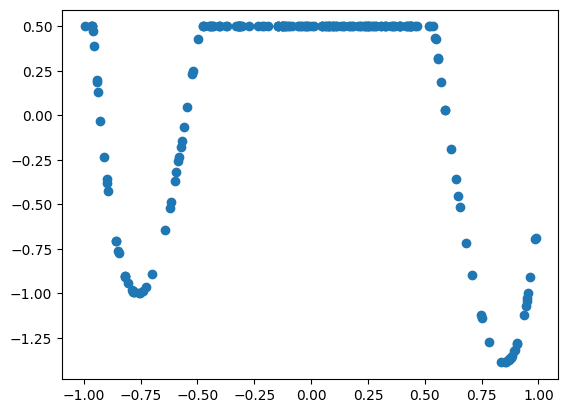

In [104]:
sampler = UniformSampler(n_dims=1)
clamped_task = get_task_sampler( "clamped_chebyshev", n_dims=1, batch_size=1,lowest_degree=4, highest_degree=4 )()

clamped_task = ClampedChebyshev(n_dims=1, batch_size=1, basis_dim=4, pool_dict=None, different_degrees=False, lowest_degree=1, highest_degree=11)
orig_task = get_task_sampler( "chebyshev_kernel_linear_regression", 1, 1)(lowest_degree=4, highest_degree=4)

num_xs_to_pred = 200

xs_context = sampler.sample_xs(255, 1)
xs_to_pred = sampler.sample_xs(num_xs_to_pred, 1)

ys_clamped_context = clamped_task.evaluate(xs_context, noise=False, separate_noise=False)
ys_clamped_to_pred = clamped_task.evaluate(xs_to_pred, noise=False, separate_noise=False)

xs_gt, ys_gt = torch.concat((xs_context.squeeze(), xs_to_pred.squeeze())), torch.concat((ys_clamped_context.squeeze(), ys_clamped_to_pred.squeeze()))

# # plot the grount truth clamped polynomial
plt.scatter(xs_to_pred.squeeze(), ys_clamped_to_pred.squeeze())

In [105]:
predicted_ys_on_context = []
xs_to_pred = xs_to_pred.squeeze()
xs_context = xs_context.squeeze()
ys_clamped_context = ys_clamped_context.squeeze()
ys_clamped_to_pred = ys_clamped_to_pred.squeeze()

for i in range(0, num_xs_to_pred):
    xs = torch.concat((xs_context, torch.tensor([xs_to_pred[i]])))
    ys = torch.concat((ys_clamped_context, torch.tensor([ys_clamped_to_pred[i]])))

    xs = xs.unsqueeze(0)    
    xs = xs.unsqueeze(-1)  

    ys = ys.unsqueeze(0)

    xs = xs.to('cuda')
    ys = ys.to('cuda')

    pred = base_model(xs, ys).detach().cpu()
    predicted_ys_on_context.append(pred.squeeze()[-1])

# plt.plot(xs_to_pred.squeeze(), np.array(predicted_ys_on_context).squeeze(), label="Predicted Clamped Polynomial")

Text(0.5, 1.0, 'Base Model: Clamping From Context')

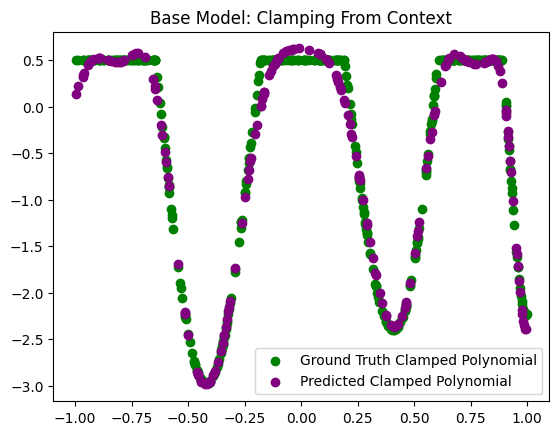

In [102]:
plt.scatter(xs_gt.squeeze(), ys_gt.squeeze(), label="Ground Truth Clamped Polynomial", color="green")
plt.scatter(xs_to_pred.squeeze(), predicted_ys_on_context, label="Predicted Clamped Polynomial", color="purple")
plt.legend()
plt.title("Base Model: Degree 4 Clamping From Context")

In [25]:
ys_clamped_context.shape
ys_clamped_to_pred.shape

torch.Size([1, 10])

In [27]:
xs_context.shape
xs_to_pred.shape

torch.Size([1, 10, 1])

In [23]:
ys_clamped_context.squeeze()[0]

tensor(-0.4156)